# Inés Dataset
To evaluate Tangles on real world data, we have obtained the dataset from the thesis of Inés. She has used an embedding algorithm on it and has visually inspected, which elements are closer together.

We will do the same with majority-Tangles.

## Data preparation


In [69]:
import sys
sys.path.append("..")
from pathlib import Path
import pandas as pd
import re
import numpy as np
import pickle
import altair as alt
from plotting import AltairPlotter
from tangles.plotting import plot_soft_predictions
from tangles.data_types import Data
from sklearn.utils import Bunch
from cblearn.embedding import SOE
from cblearn.preprocessing import triplets_from_mostcentral, triplets_from_oddoneout
import matplotlib.pyplot as plt
from triplets import triplets_to_majority_neighbour_cuts
from estimators import OrdinalTangles

In [27]:
# getting all the folders that contain triplet data
dataset_root = Path(r"/Users/almico/datasets/2021_similarity-triplets_object-images_ines-bsc")
data_root = dataset_root / "data_similarity_judgements"
vp_folders = [p for p in data_root.iterdir() if p.is_dir() and re.match(r"VP_\d+", p.stem) is not None]
dfs = []
# bringing the data into a a more workable format
for vp in vp_folders:
    experiment_re = r"similarity_judgements_(\d+)_session_(.*).csv"
    csv_files = [p for p in vp.iterdir() if re.match(experiment_re, p.stem) is not None]
    for f in vp.iterdir():
        search = re.search(experiment_re, f.name)
        if search is None:
            continue
        vp_number = search.group(1)
        kind = search.group(2)
        dfs.append(pd.read_csv(f).assign(vp_number=vp_number, exp_kind = kind))
    
df = pd.concat(dfs)
# There was apparently some error in naming 
df.replace("fork_plastic_light.jp","fork_plastic_light.jpg", inplace=True)
df.head()

,subj,age,session,trial,RT,response,imagenameleft,imagenamemiddle,imagenameright,imageset,vp_number,exp_kind
0,1.0,27.0,odd,1.0,1.961037,left,letter_opener_10s.jpg,key_08s.jpg,key_07s.jpg,action,1,odd
1,1.0,27.0,odd,2.0,1.552606,right,stump_08s.jpg,tree_ines.jpg,stick_insect_09.jpg,taxonomic,1,odd
2,1.0,27.0,odd,3.0,2.102521,left,leaf_04s.jpg,stick_insect_09.jpg,bee_01b.jpg,taxonomic,1,odd
3,1.0,27.0,odd,4.0,4.968988,left,screwdriver_04s.jpg,coin_14s.jpg,key_01b.jpg,action,1,odd
4,1.0,27.0,odd,5.0,1.705614,middle,pitchfork_02s.jpg,hay_10s_cut.jpg,pitchfork_09s.jpg,thematic,1,odd


This is the raw data. We will now process this into a triplet-response format.

In [28]:
imagenames = df[["imagenameleft", "imagenamemiddle", "imagenameright"]]
unique_names = np.unique(imagenames.to_numpy().flatten())
image_number_correspondence = np.arange(0, unique_names.size)
indices = np.argmax(imagenames.to_numpy()[:, :, None] == unique_names[None, None, :], axis=2)

triplets = indices
responses = np.argmax(df["response"].to_numpy()[:, None] == np.array(["left", "middle", "right"])[None, :], axis=1)

assert np.all(df["response"].to_numpy()[[0, 4, 1]] == np.array(["left", "middle", "right"]))
assert np.all(responses[[0, 4, 1]] == np.array([0,1,2]))

Since the triplets and responses have to be accessed in a highly unique fashion, 
we will include the whole dataframe in the end. We will now append the triplets and responses to it.

In [29]:
df[["triplet_left", "triplet_middle", "triplet_right"]] = triplets
df["triplet_response"] = responses

Next, we want to provide a dictionary that gives us some more information about the images.

In [30]:
image_info_dict = {}
for i, name in enumerate(unique_names):
    num = image_number_correspondence[i]
    image_info_dict[name] = {"idx": num}
for imageset in ["action", "taxonomic", "thematic"]:
    for im in (dataset_root / f"{imageset}_stimuli").iterdir():
        image_info_dict[im.name]["imageset"] = imageset
        image_info_dict[im.name]["class"] = re.search(r"([a-z]+)_.*\.jpg", im.name).group(1)
# now revert the dictionary to make better use of it
image_info_dict = {v["idx"]: {"name": k, "imageset": v["imageset"], "class": v["class"]} for k, v in image_info_dict.items()}

Now we export one complete dictionary that can be serialized to JSON.

In [31]:
master_bunch = Bunch(data=df, image_info=image_info_dict)
# JSON doesn't like numpy arrays.
pickle.dump(master_bunch, open(Path("results") /"data_ines.pkl", "wb"))

Read again in the same manner:

In [32]:
ines_data = pickle.load(open(Path("results") /"data_ines.pkl", "rb"))

## Exploring the dataset
We will now see what insights we can gain from the data.

### Odd similarity triplets
We will start out with the odd triplets, as they were easier to embed (see Bachelor thesis
of Inés).

In [65]:
imageset = "thematic"
exp_kind = "odd"
vp_number = "1"
def triplet_responses_from_df(df):
    return df[["triplet_left", "triplet_middle", "triplet_right"]].to_numpy(), df["triplet_response"].to_numpy()
df_filtered = df[(df.exp_kind == exp_kind) & (df.vp_number == vp_number) & (df.imageset == imageset)]
t = triplets_from_oddoneout(*triplet_responses_from_df(df_filtered))
r = np.ones(t.shape[0])
indices_in_imageset = [k for k, v in image_info_dict.items() if v["imageset"] == imageset]

In [66]:
embedding = SOE(n_components = 2, random_state=2).fit_transform(t,r)
cuts = triplets_to_majority_neighbour_cuts(t, radius = 1)
tangles = OrdinalTangles(3)
tangles_pred = tangles.fit_predict(cuts)
embedding_in_imageset = embedding[indices_in_imageset, :]
tangles_pred_in_imageset = tangles_pred[indices_in_imageset]

/opt/homebrew/Caskroom/mambaforge/base/envs/tangles-thesis/lib/python3.9/site-packages/tangles/utils.py:54: RuntimeWarning: invalid value encountered in true_divide
  return (array - np.min(array)) / np.ptp(array)


In [67]:
#plt.scatter(embedding_in_imageset[:, 0], embedding_in_imageset[:, 1], marker=u"+")
classes = [ines_data.image_info[i]["class"] for i in indices_in_imageset]
df_plot = pd.DataFrame({"x": embedding_in_imageset[:, 0], "y": embedding_in_imageset[:, 1], "tangles": tangles_pred_in_imageset.astype(int), "class": classes})
alt.Chart(df_plot).mark_circle(size=70).encode(x="x", y="y", color="tangles:N").display()
alt.Chart(df_plot).mark_circle(size=70).encode(x="x", y="y", color="class").display()

alt.Chart(...)

alt.Chart(...)

In [79]:
df_filtered

,subj,age,session,trial,RT,response,imagenameleft,imagenamemiddle,imagenameright,imageset,vp_number,exp_kind,triplet_left,triplet_middle,triplet_right,triplet_response
4,1.0,27.0,odd,5.0,1.705614,middle,pitchfork_02s.jpg,hay_10s_cut.jpg,pitchfork_09s.jpg,thematic,1,odd,48,20,51,1
11,1.0,27.0,odd,12.0,3.303421,left,fork_plastic_light.jpg,pitchfork_03s.jpg,hay_03s.jpg,thematic,1,odd,16,49,19,0
12,1.0,27.0,odd,13.0,2.183908,right,pitchfork_04s.jpg,straw_01.jpg,fork_06s.jpg,thematic,1,odd,50,62,14,2
16,1.0,27.0,odd,17.0,1.772773,middle,straw_01.jpg,fork_05s.jpg,straw_hay_01b.jpg,thematic,1,odd,62,13,64,1
26,1.0,27.0,odd,27.0,3.083185,right,hay_10s_cut.jpg,straw_01.jpg,pitchfork_16s.jpg,thematic,1,odd,20,62,53,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,1.0,27.0,odd,242.0,2.383371,middle,pitchfork_15s.jpg,straw_01.jpg,pitchfork_16s.jpg,thematic,1,odd,52,62,53,1
754,1.0,27.0,odd,243.0,0.794440,right,straw_hay_01b.jpg,straw_02.jpg,dishwasher_07s.jpg,thematic,1,odd,64,63,8,2
755,1.0,27.0,odd,244.0,1.252807,middle,dishwasher_03s.jpg,hay_02s.jpg,dishwasher_09s.jpg,thematic,1,odd,6,18,9,1
757,1.0,27.0,odd,246.0,1.052448,middle,dishwasher_12n.jpg,fork_05s.jpg,dishwasher_09s.jpg,thematic,1,odd,11,13,9,1


In [64]:
cuts = triplets_to_majority_neighbour_cuts(t, radius = 1/4)

for a in range(3,10):
    for radius in [1/4, 1/3, 1/2, 1]:
        cuts = triplets_to_majority_neighbour_cuts(t, radius = radius)
        tangles_pred = OrdinalTangles(a).fit_predict(cuts)
        tangles_pred_in_imageset = tangles_pred[indices_in_imageset]
        df_plot = pd.DataFrame({"x": embedding_in_imageset[:, 0], "y": embedding_in_imageset[:, 1], "tangles": tangles_pred_in_imageset.astype(int), "class": classes})
        alt.Chart(df_plot).mark_circle(size=70).encode(x="x", y="y", color="tangles:N").properties(title=f"a={a}, radius={radius}")#.display()

We can see that a radius of 1 is generally okay. Lowering the radius makes the cuts lower, but that is not that important, since the tangles-algorithm does its work.

Maybe soft cuts can really shine here.

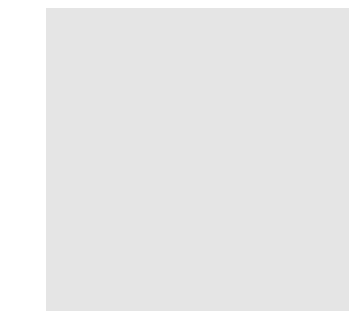

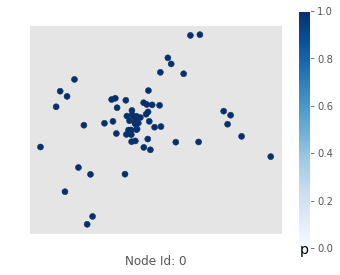

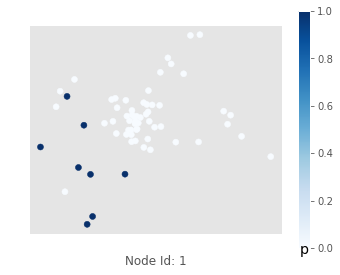

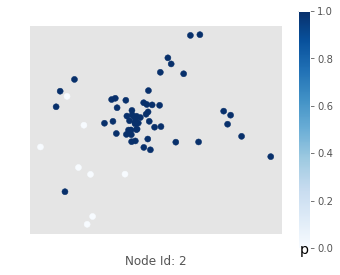

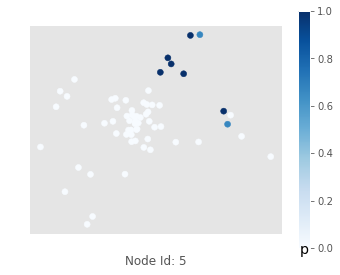

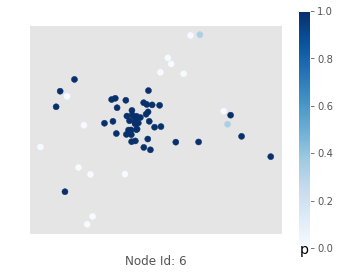

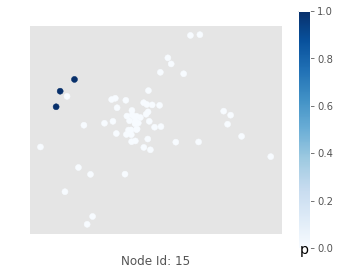

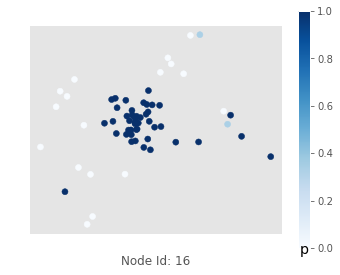

In [78]:
aux_data = Data(embedding, np.ones(cuts.shape[0]))
plot_soft_predictions(aux_data, tangles.contracted_tangles_tree_, tangles.cuts_.values)
